In [267]:
# The very first version of Neural Network 
#-------------------------------------------------------------------------
# This Neural Networks works with the from Wisconsin cancer dataset
#07/26/2019 - first workable version!

In [268]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [269]:
#Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [270]:
#Derivativ of the Activation function
def sigmoid_derivative(x):
    return x * (1 - x)

In [271]:
def cout(x):
    if np.ndim(x) == 2:
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if x[i][j] >= 0.5:
                    x[i][j] = 1
                else:
                    x[i][j] = 0
    elif np.ndim(x) == 1:
        for i in range(x.shape[0]):
            if x[i] >= 0.5:
                x[i] = 1
            else:
                x[i] = 0
    return x

In [272]:
#Neural Network
class NeuralNetwork:
    def __init__(self, Input, Output, Input_test, Output_test, NNstructure = [20, 20, 20]):
        # Variables
        self.Input = np.hstack((np.ones((Input.shape[0],1)), Input))
        self.Output = Output
        
        self.Input_test = np.hstack((np.ones((Input_test.shape[0],1)), Input_test))
        self.Output_test = Output_test
        #Number of features
        self.n = self.Input.shape[1]
        #Number of Examples
        self.m = self.Input.shape[0]
        #Neural Network strucutre (number of nodes)
        self.layer_1_nodes = NNstructure[0]
        self.layer_2_nodes = NNstructure[1]
        self.layer_3_nodes = NNstructure[2]

        classes =1 
        
        self.weights_1_init = 2 * np.random.random((self.n, self.layer_1_nodes)) - 1
        self.weights_2_init = 2 * np.random.random((self.layer_1_nodes, self.layer_2_nodes)) - 1
        self.weights_3_init = 2 * np.random.random((self.layer_2_nodes, self.layer_3_nodes)) - 1
        self.weights_out_init = 2 *np.random.random((self.layer_3_nodes, classes)) - 1
    
    #Forward propagation 
    def Forward_Propagation(self, x):
        if np.ndim(x) == 2:
            if x.shape[1] == self.n -1:
                x = np.hstack((np.ones((x.shape[0],1)), x))
        elif np.ndim(x) == 1:
            if x.shape[0] == self.n -1:
                x = np.hstack((np.ones((1,)), x))
                
        self.layer_1 = sigmoid(np.dot(x, self.weights_1))
        self.layer_2 = sigmoid(np.dot(self.layer_1, self.weights_2))
        self.layer_3 = sigmoid(np.dot(self.layer_2, self.weights_3))
        self.prediction = sigmoid(np.dot(self.layer_3, self.weights_out))
        return self.prediction
    
    #trainin the Neural Network
    def train(self, num_iter = 500):
        self.weights_1 = self.weights_1_init
        self.weights_2 = self.weights_2_init
        self.weights_3 = self.weights_3_init
        self.weights_out = self.weights_out_init
        alpha = 0.0003
        lam = 0.25
        beta = 0.9
        eps = 10 ** (-8)
        self.CostHistory = []
        self.CostHistory_test = []
        self.AccTrain = []
        self.AccTest = []
        VdW_out = np.zeros(self.weights_out.shape)
        VdW_3 = np.zeros(self.weights_3.shape)
        VdW_2 = np.zeros(self.weights_2.shape)
        VdW_1 = np.zeros(self.weights_1.shape)
        for x in range(num_iter):
            prediction_test = self.Forward_Propagation(self.Input_test)
            prediction = self.Forward_Propagation(self.Input)
            
            #Cost Function
            outputError = prediction - self.Output
            CostFunction = (len(self.Output))**-1 * sum(-self.Output * np.log(prediction) - (1-self.Output) * np.log(1-prediction))              
            self.CostHistory.append(*CostFunction)
            
            outputError_test = prediction_test - self.Output_test
            CostFunction_test =(len(self.Output_test))**-1 * sum(- self.Output_test * np.log(prediction_test) - (1-self.Output_test) * np.log(1-prediction_test))
            self.CostHistory_test.append(*CostFunction_test)
            #Accuracy
            self.AccTrain.append(1.0- (sum(abs(cout(prediction) - self.Output)) / self.Output.shape[0]))
            self.AccTest.append(1.0 - (sum(abs(cout(prediction_test) - self.Output_test)) / self.Output_test.shape[0]))

            string = '<'+'█'*round((x)/num_iter*40)+'_'*(40-round((x)/num_iter*40))+'>'
            print('\r{}% {} Cost function = {}'.format(round((x+1)/num_iter*100,1),string,*CostFunction),end='')
            
            #Back Propagation with RMSprop
            delta = outputError   
            dW_out = np.dot(self.layer_3.T, delta)
            VdW_out = VdW_out * beta + (1-beta)* dW_out**2
            self.weights_out += - alpha*dW_out / (VdW_out + eps)**0.5 - lam/self.m * self.weights_out
                                   
            delta = np.dot(delta, self.weights_out.T) * sigmoid_derivative(self.layer_3)
            dW_3 = np.dot(self.layer_2.T, delta)
            VdW_3 = VdW_3 * beta + (1-beta)*dW_3**2
            self.weights_3 += - alpha*dW_3 / (VdW_3 + eps)**0.5 - self.weights_3* lam/self.m
            
            delta = np.dot(delta, self.weights_3.T) * sigmoid_derivative(self.layer_2)
            dW_2 = np.dot(self.layer_1.T, delta)
            VdW_2 = VdW_2 * beta + (1-beta)*dW_2**2
            self.weights_2 += - alpha*dW_2 / (VdW_2 + eps)**0.5 - self.weights_2*lam/self.m
            
            delta = np.dot(delta, self.weights_2.T) * sigmoid_derivative(self.layer_1)
            dW_1 = np.dot(self.Input.T, delta)
            VdW_1 = VdW_1 * beta + (1-beta)*dW_1**2
            self.weights_1 += - alpha*dW_1 / (VdW_1 + eps)**0.5 - self.weights_1*lam/self.m
            
        
        print('\nFinal cost function: {}'.format(*CostFunction))
        print('\nTraining successfully complete!')
        

In [273]:
def LoadData(filename, inp_train):
    file= pd.read_csv(filename, delimiter = ',')
    dataset = file.values
    np.random.shuffle(dataset)
    Input = dataset[:,1:10]
    Output_initial = dataset[:,10]
    OutputX = []
    for i in Output_initial:
        if i == 2:
            g = 0
        else:
            g = 1
        OutputX.append(g)
    OutputX = np.array(OutputX).reshape(Output_initial.shape[0],1)
    Output = OutputX[:inp_train, :]
    Output_test = OutputX[inp_train:, :]
    data_train = Input[:inp_train, :].astype('float32') / 10
    data_test = Input[inp_train:, :].astype('float32') / 10
    
    return Output, Output_test, data_train, data_test

Enter training set size in percent: 80
Number of iterations: 2000
Trainin Neural Network for 2000 iterations 

100.0% <████████████████████████████████████████> Cost function = 0.07672190103857826
Final cost function: [0.0767219]

Training successfully complete!
Accuracy on training data: [0.97674419]%
Accuracy on test data: [0.9352518]%


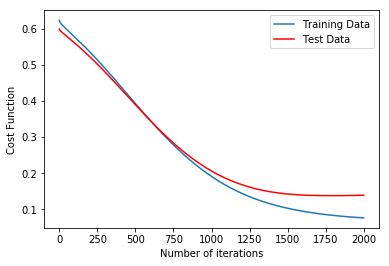

In [274]:
if __name__ == '__main__':
    filename = 'breast-cancer-wisconsin.txt'
    inp_train = round((int(input('Enter training set size in percent: ')) / 100) * 699)
    Output, Output_test, data_train, data_test = LoadData(filename, inp_train)
    
    neural_network = NeuralNetwork(data_train, Output, data_test, Output_test)
    
    num_iter = int(input('Number of iterations: '))
    print('Trainin Neural Network for {} iterations \n'.format(num_iter))   
    neural_network.train(num_iter)
    
    print('Accuracy on training data: {}%\nAccuracy on test data: {}%'.format(neural_network.AccTrain[-1], neural_network.AccTest[-1]))
   #print('Prediction for Test data: \n{}'.format(*neural_network.Forward_Propagation(data_test).T))
    
    plt.plot(range(num_iter),neural_network.CostHistory, label = 'Training Data')
    plt.plot(range(num_iter),neural_network.CostHistory_test, 'r', label = 'Test Data')
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost Function')
    plt.legend()
    plt.show()